In [3]:
!python --version

Python 3.10.5


In [2]:
os.getcwd()

'/home/paul/Research/Alzheimer-Detection'

In [7]:
#Preprocessing code borrowed from Fabrizio Ravelli: https://www.kaggle.com/code/fabrizioravelli/alzheimer-s-disease-classification-98-acc

import os
import cv2
import random
from tqdm import tqdm
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras.backend as K

from keras import models
from keras import layers
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import Model



CLASSES = ("MILD_DEMENTED", "NON_DEMENTED", "VERYMILD_DEMENTED")
DATASET_DIR = "data/"
TEST_DIR = DATASET_DIR + "test/"
TRAINING_DIR = DATASET_DIR + "train/"

IMG_SIZE = 100

def create_data(directory):
    data = []
    for CLASSE in CLASSES:
        path = os.path.join(directory, CLASSE)
        class_num = CLASSES.index(CLASSE)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append((img_array, class_num))
            
    return data

train_data = create_data(TRAINING_DIR)
test_data = create_data(TEST_DIR)

random.shuffle(train_data)
random.shuffle(test_data)

def prepare_data(data):
    inp = []
    out = []
    
    for img, label in data:
        inp.append(img)
        y = np.zeros(len(CLASSES))
        y[label] = 1
        out.append(y)
    inp = np.array(inp).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    
    return inp, out

X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

X_train = X_train / 255
y_train = np.array(y_train)

X_test = X_test / 255
y_test = np.array(y_test)

for classe in CLASSES:
    class_num = CLASSES.index(classe)
    print(classe, class_num)


100%|█████████████████| 224/224 [00:00<00:00, 779.75it/s]


MILD_DEMENTED 0
NON_DEMENTED 1
VERYMILD_DEMENTED 2


Text(0.5, 0, 'Mild Demented')

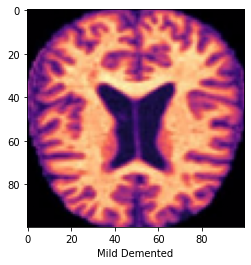

In [8]:
plt.imshow(X_train[6:7][0,:,:,:])
plt.xlabel("Mild Demented")

Text(0.5, 0, 'Very Mild Demented')

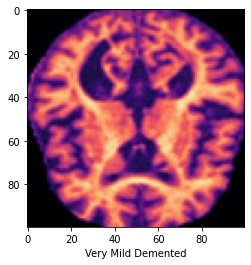

In [9]:
plt.imshow(X_train[37:38][0,:,:,:])
plt.xlabel("Very Mild Demented")

Text(0.5, 0, 'Non Demented')

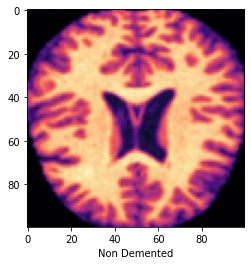

In [10]:
plt.imshow(X_train[65:66][0,:,:,:])
plt.xlabel("Non Demented")

In [11]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', name='last_conv_layer'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(CLASSES), activation='softmax')], name='modelv1')

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

model.summary()

2022-08-15 11:42:04.264303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 11:42:04.332497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 11:42:04.334714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "modelv1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 average_pooling2d (AverageP  (None, 49, 49, 32)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 49, 49, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 23, 23, 64)       0         
 ePooling2D)                                                     
                                                           

2022-08-15 11:42:04.337584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-15 11:42:04.338956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 11:42:04.341196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 11:42:04.343309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1)

Epoch 1/100


2022-08-15 11:42:23.357371: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


161/161 [==============================] - 7s 21ms/step - loss: 0.9532 - acc: 0.6009 - prec: 0.6078 - rec: 0.5805 - auc: 0.8068 - val_loss: 1.4397 - val_acc: 0.3702 - val_prec: 0.3702 - val_rec: 0.3702 - val_auc: 0.6570
Epoch 2/100
161/161 [==============================] - 2s 15ms/step - loss: 0.6771 - acc: 0.6362 - prec: 0.6496 - rec: 0.6201 - auc: 0.8515 - val_loss: 0.9975 - val_acc: 0.4702 - val_prec: 0.4888 - val_rec: 0.4614 - val_auc: 0.7274
Epoch 3/100
161/161 [==============================] - 2s 15ms/step - loss: 0.6194 - acc: 0.6684 - prec: 0.6787 - rec: 0.6442 - auc: 0.8717 - val_loss: 1.4114 - val_acc: 0.5140 - val_prec: 0.5276 - val_rec: 0.5035 - val_auc: 0.7328
Epoch 4/100
161/161 [==============================] - 2s 15ms/step - loss: 0.6175 - acc: 0.6542 - prec: 0.6666 - rec: 0.6294 - auc: 0.8703 - val_loss: 0.5834 - val_acc: 0.6825 - val_prec: 0.6900 - val_rec: 0.6754 - val_auc: 0.8834
Epoch 5/100
161/161 [==============================] - 3s 17ms/step - loss: 0.5839 -

In [13]:
test_scores = model.evaluate(X_test, y_test)

print("Testing Loss: %.2f%%"%(test_scores[0] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
print("Testing Precision: %.2f%%"%(test_scores[2] * 100))
print("Testing Recall: %.2f%%"%(test_scores[3] * 100))
print("Testing AUC: %.2f%%"%(test_scores[4] * 100))


20/20 [==============================] - 0s 13ms/step - loss: 0.1745 - acc: 0.9668 - prec: 0.9684 - rec: 0.9668 - auc: 0.9909
Testing Loss: 17.45%
Testing Accuracy: 96.68%
Testing Precision: 96.84%
Testing Recall: 96.68%
Testing AUC: 99.09%


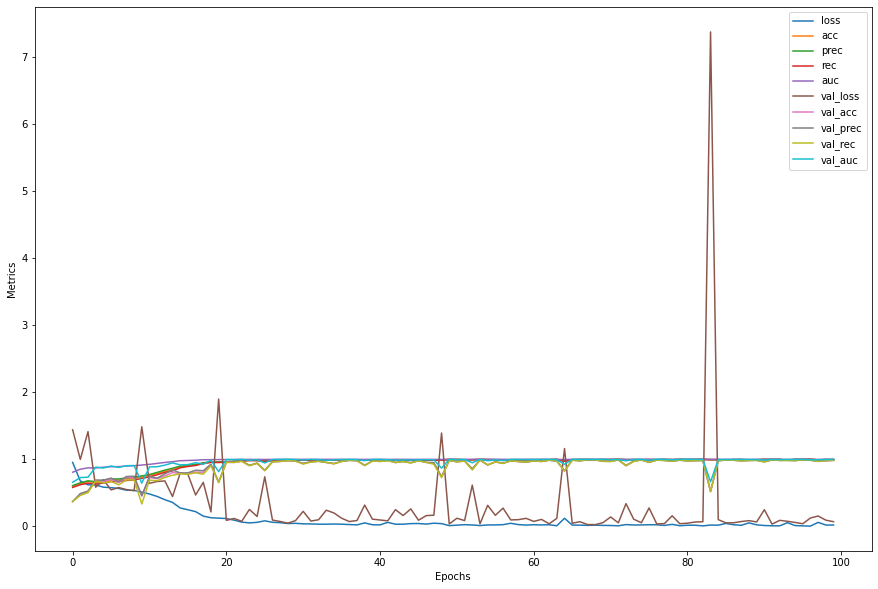

In [14]:
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()